In [2]:
import numpy as np
import pandas as pd
import joblib
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

In [3]:
# -------------------------------
# Model Loading and Data Preparation
# -------------------------------
print("="*80)
print("SECTION 1: MODEL LOADING AND FEATURE ANALYSIS")
print("="*80)

# Load the pre-trained model
print("\n1.1 Loading Pre-trained Model and Test Data")
print("Loading pre-trained model...")
xgb_model = joblib.load('Models/xgboost_model_weighted.joblib')
print("Model loaded successfully!")
# Load the test data
print("Loading test data...")
X_train = pd.read_csv('data/training/X_train_processed.csv')
X_test = pd.read_csv('data/training/X_test_processed.csv')
y_test = pd.read_csv('data/training/y_test_processed.csv')
print(f"Test data shape: {X_test.shape}")

SECTION 1: MODEL LOADING AND FEATURE ANALYSIS

1.1 Loading Pre-trained Model and Test Data
Loading pre-trained model...
Model loaded successfully!
Loading test data...
Test data shape: (76911, 40)


In [3]:
# -------------------------------
# 1.2 Select Instances Based on Prediction Probabilities
# -------------------------------
# Calculate predicted probabilities for the positive class
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Find one approved instance (high probability)
approved_candidates = np.where(y_proba > 0.7)[0]
approved_idx = np.random.choice(approved_candidates)

# Find one rejected instance (low probability)
rejected_candidates = np.where(y_proba < 0.3)[0]
rejected_idx = np.random.choice(rejected_candidates)

# Find one borderline instance (probability close to 0.5)
borderline_idx_candidates = np.where((y_proba >= 0.50) & (y_proba <= 0.55))[0]
if len(borderline_idx_candidates) > 0:
    borderline_idx = borderline_idx_candidates[0]
else:
    # If no candidate is found, choose the instance with probability closest to 0.5
    borderline_idx = np.argmin(np.abs(y_proba - 0.5))

# Create a DataFrame with the three selected instances
selected_indices = [approved_idx, rejected_idx, borderline_idx]
instances = X_test.iloc[selected_indices].reset_index(drop=True)
print("Selected instance indices:", selected_indices)
print("Selected instances:\n", instances)

# -------------------------------
# Print Predicted Probabilities and Actual Values for Selected Instances
# -------------------------------
print("\nPredicted probabilities and actual values for selected instances:")
for i, idx in enumerate(selected_indices):
    pred_prob = y_proba[idx]
    # Assuming y_test is a DataFrame with one column; adjust if there are multiple columns
    actual_value = y_test.iloc[idx, 0] if y_test.shape[1] == 1 else y_test.iloc[idx].to_dict()
    print(f"Instance {idx}: Predicted Probability = {pred_prob:.3f}, Actual Value = {actual_value}")


Selected instance indices: [75040, 6782, 9]
Selected instances:
    loan_amount_k  applicant_income_k  co_applicant_status  \
0             71               133.0                    1   
1            589                81.0                    1   
2            352                56.0                    1   

   loan_to_income_ratio  loan_type_Conventional  loan_type_FHA-insured  \
0              0.533835                       1                      0   
1              7.271605                       0                      1   
2              6.285714                       1                      0   

   loan_type_FSA/RHS-guaranteed  loan_type_VA-guaranteed  \
0                             0                        0   
1                             0                        0   
2                             0                        0   

   purpose_Home improvement  purpose_Home purchase  ...  \
0                         0                      1  ...   
1                         0       


Generating SHAP waterfall and decision plots for each selected instance...

Processing instance 75040 (Index 0 in selection):


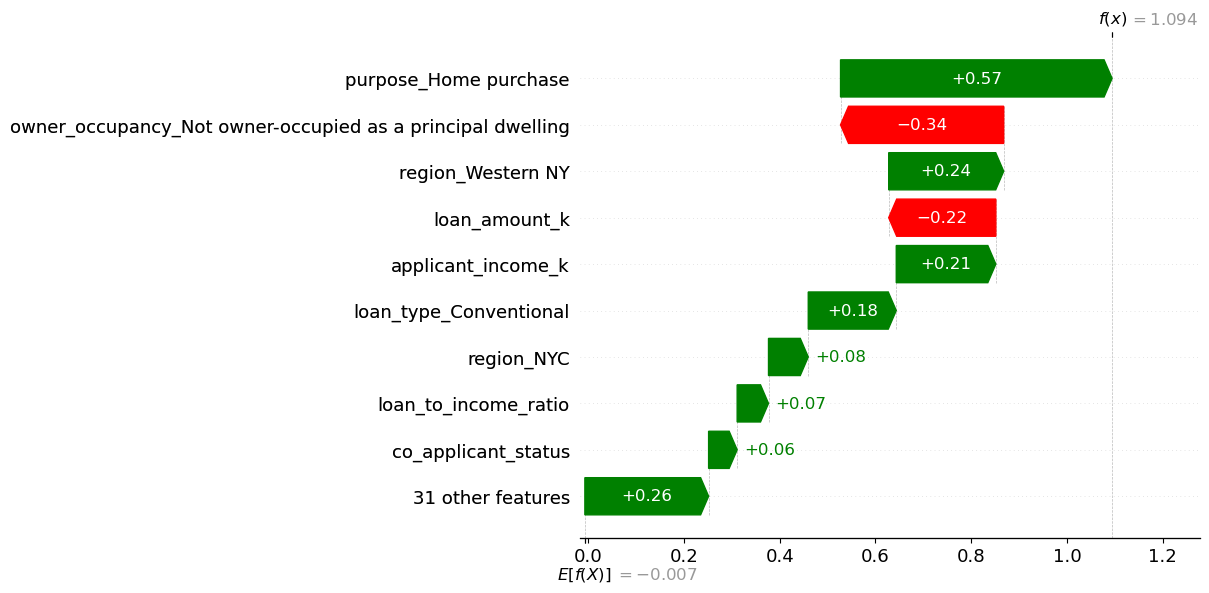

Waterfall plot saved to: SHAP/instance_75040/waterfall_plot_75040.png


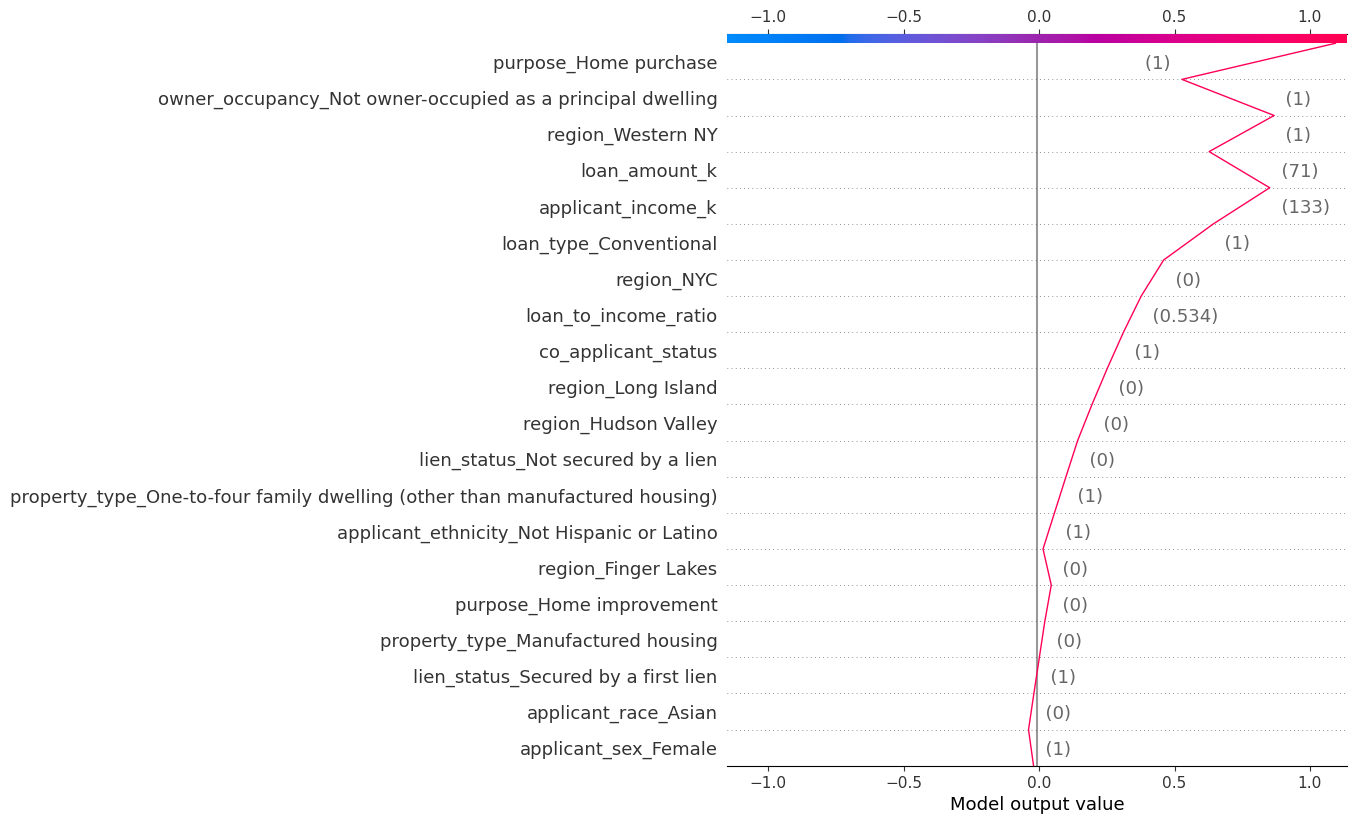

Decision plot saved to: SHAP/instance_75040/decision_plot_75040.png

Processing instance 6782 (Index 1 in selection):


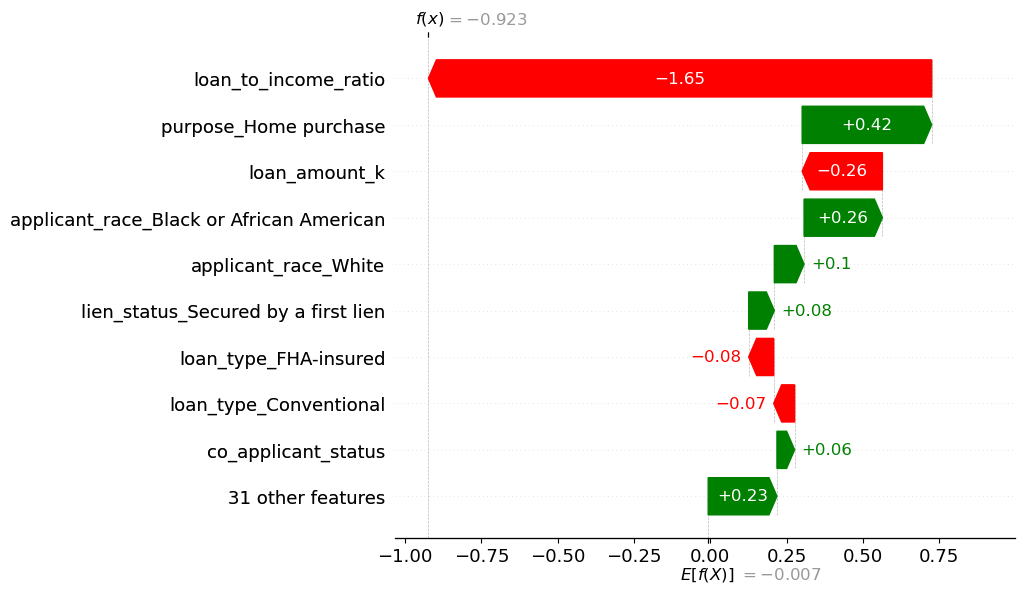

Waterfall plot saved to: SHAP/instance_6782/waterfall_plot_6782.png


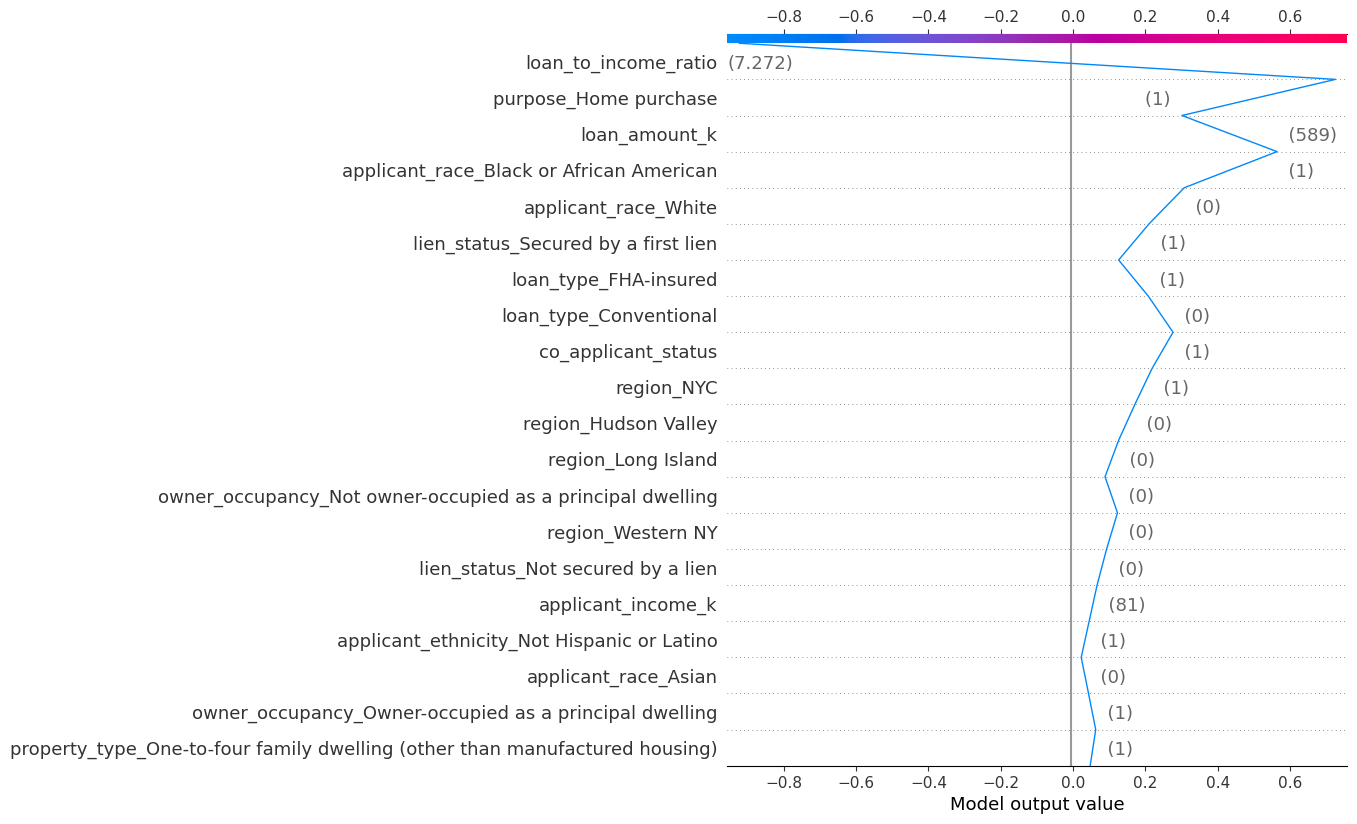

Decision plot saved to: SHAP/instance_6782/decision_plot_6782.png

Processing instance 9 (Index 2 in selection):


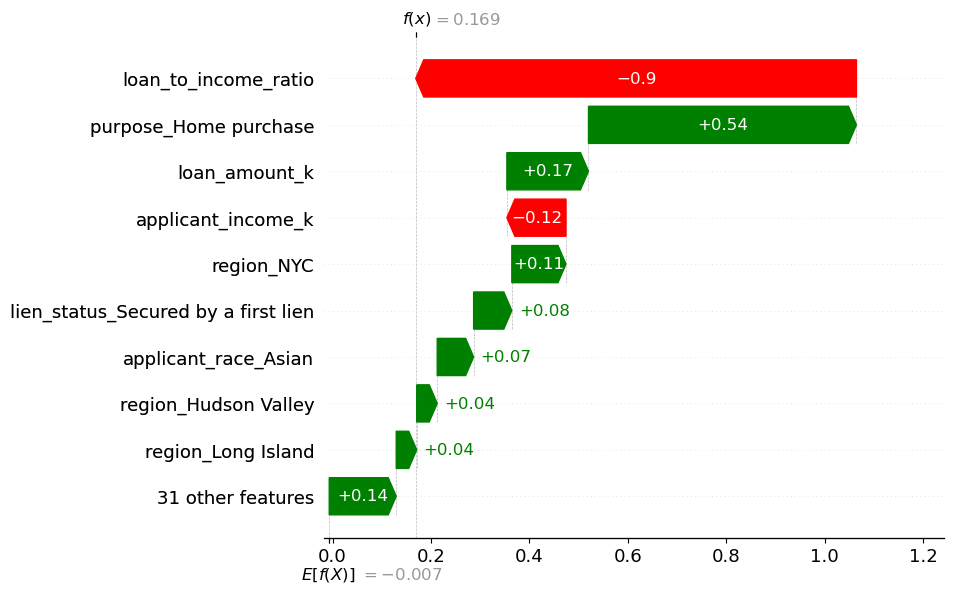

Waterfall plot saved to: SHAP/instance_9/waterfall_plot_9.png


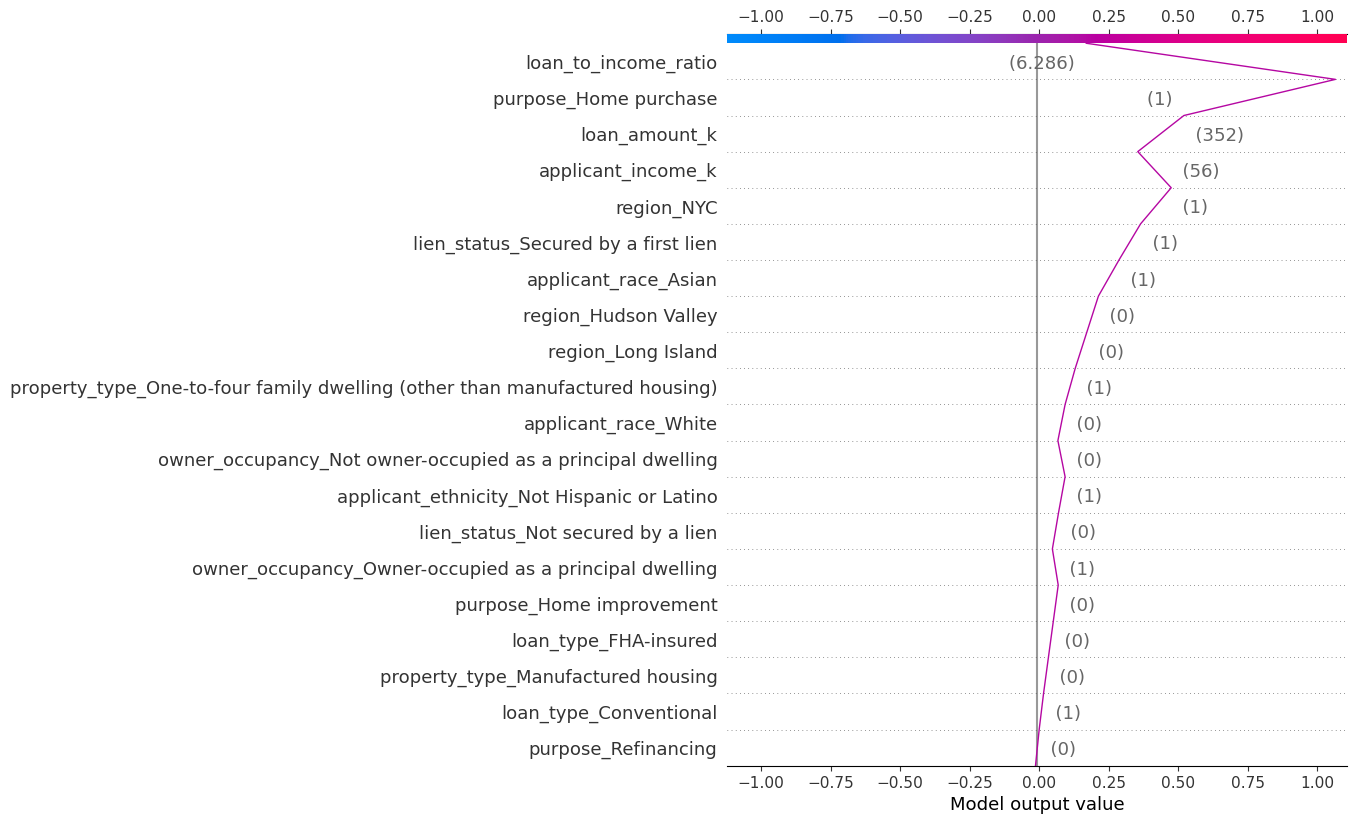

Decision plot saved to: SHAP/instance_9/decision_plot_9.png


In [4]:
import os
import matplotlib.pyplot as plt
import shap
from shap.plots._style import style_context

# Turns off interactive mode so figures render in the background
plt.ioff()

# Create a base folder for SHAP outputs
base_folder = "SHAP"
os.makedirs(base_folder, exist_ok=True)

# Creates a SHAP explainer for the tree-based model (XGBoost)
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the selected instances
shap_values = explainer.shap_values(instances)

print("\nGenerating SHAP waterfall and decision plots for each selected instance...")

for i in range(len(instances)):
    # Creates a unique folder for each instance using the selected index value
    instance_folder = os.path.join(base_folder, f"instance_{selected_indices[i]}")
    os.makedirs(instance_folder, exist_ok=True)
    
    print(f"\nProcessing instance {selected_indices[i]} (Index {i} in selection):")
    
    # -----------------------------
    # Waterfall Plot (with custom colors)
    # -----------------------------
    with style_context(
        primary_color_positive="green",  
        primary_color_negative="red"   
    ):
        fig = plt.figure(figsize=(12,8))
        shap.plots._waterfall.waterfall_legacy(
            explainer.expected_value,
            shap_values[i, :],
            feature_names=instances.columns.tolist(),
            show=False
        )
        waterfall_path = os.path.join(
            instance_folder,
            f"waterfall_plot_{selected_indices[i]}.png"
        )
        fig.savefig(waterfall_path, bbox_inches='tight')
        plt.show()
        plt.close(fig)
    print(f"Waterfall plot saved to: {waterfall_path}")
    
    # -----------------------------
    # Decision Plot
    # -----------------------------
    fig = plt.figure(figsize=(12,8))
    shap.decision_plot(
        explainer.expected_value,
        shap_values[i, :],
        instances.iloc[i, :],
        show=False
    )
    decision_path = os.path.join(
        instance_folder,
        f"decision_plot_{selected_indices[i]}.png"
    )
    fig.savefig(decision_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Decision plot saved to: {decision_path}")


In [5]:
print(shap.__version__)

0.47.1



Generating LIME visualizations for each selected instance...

LIME explanation for instance 75040 (selection index 0):


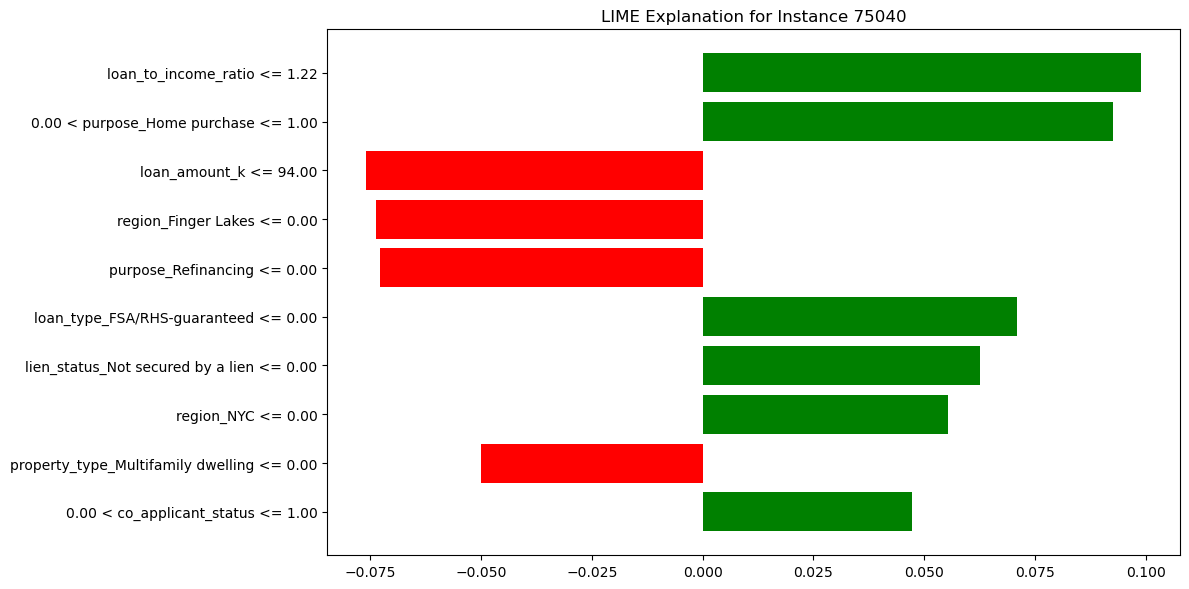

LIME explanation plot saved to: LIME/instance75040/limeexplanation75040.png

LIME explanation for instance 6782 (selection index 1):


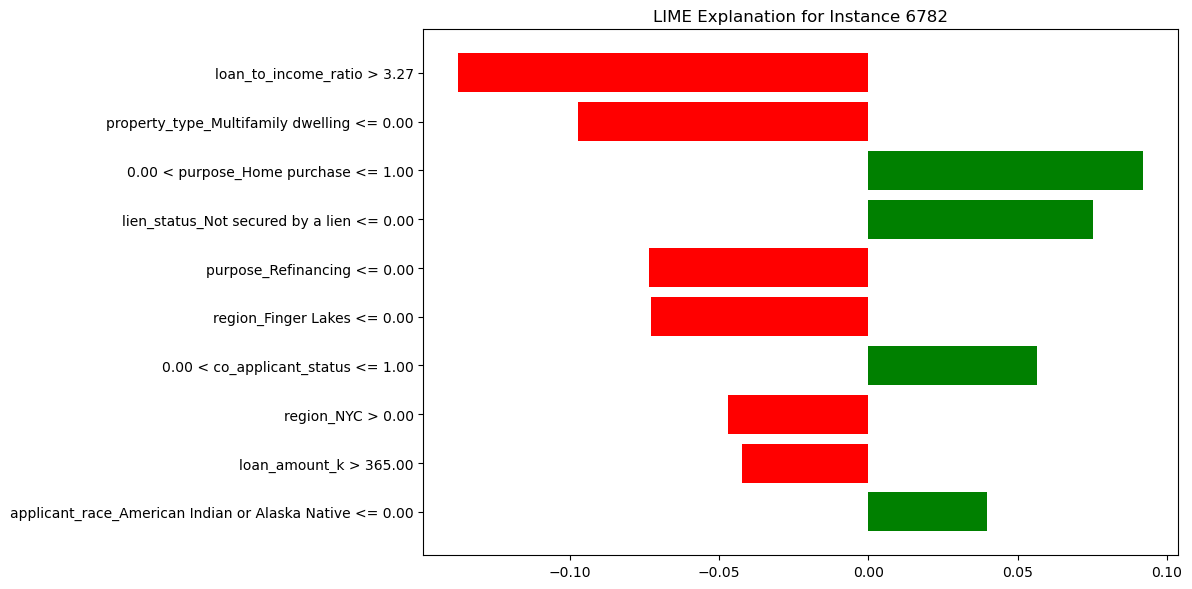

LIME explanation plot saved to: LIME/instance6782/limeexplanation6782.png

LIME explanation for instance 9 (selection index 2):


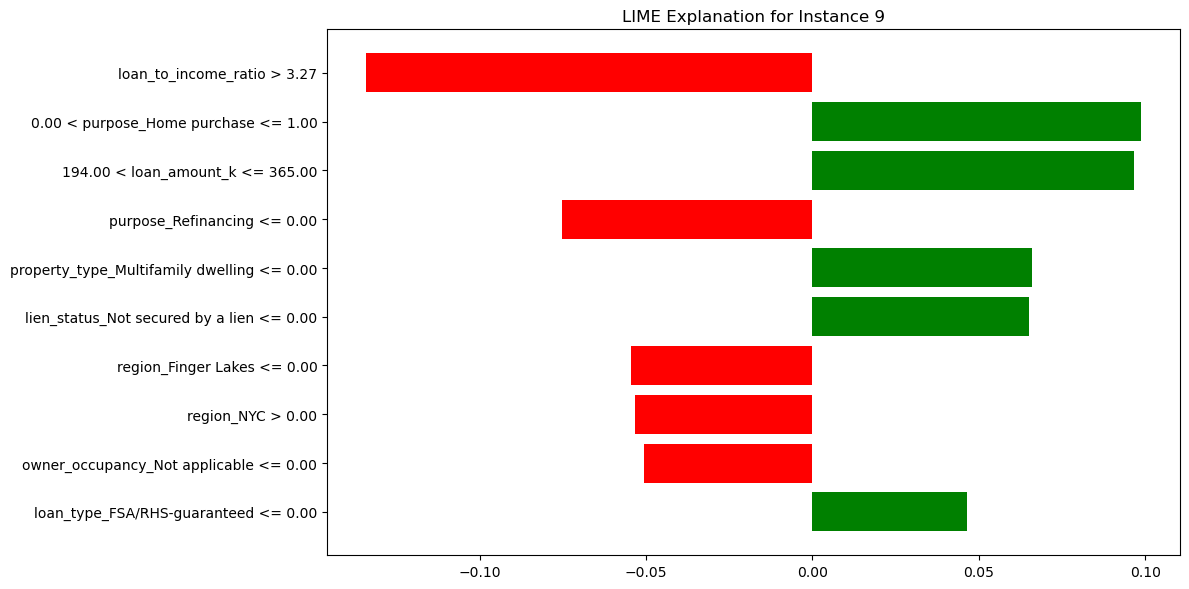

LIME explanation plot saved to: LIME/instance9/limeexplanation9.png


In [6]:
import os
import matplotlib.pyplot as plt

# Create a base folder for LIME outputs
base_folder = "LIME"
os.makedirs(base_folder, exist_ok=True)

# Create a LIME explainer using the training/test data
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_test.values,
    feature_names=X_test.columns,
    class_names=['Rejected', 'Approved'],
    discretize_continuous=True,
    mode='classification',
    random_state=42 
)

print("\nGenerating LIME visualizations for each selected instance...")

for i in range(len(instances)):
    instance_index = selected_indices[i]
    # Create a subfolder for the current instance
    instance_folder = os.path.join(base_folder, f"instance{instance_index}")
    os.makedirs(instance_folder, exist_ok=True)
    
    print(f"\nLIME explanation for instance {instance_index} (selection index {i}):")
    exp = lime_explainer.explain_instance(
        instances.iloc[i].values,
        xgb_model.predict_proba,
        num_features=10
    )
    
    # Generate a static bar chart for the explanation
    fig = exp.as_pyplot_figure()
    
    fig.set_size_inches(12, 6)  # 12 inches wide and 6 inches tall

    plt.title(f"LIME Explanation for Instance {instance_index}")
    
    # Adjust the layout so nothing is cut off
    plt.tight_layout()
    
    # Save the figure with tight bounding box to capture all elements
    file_path = os.path.join(instance_folder, f"limeexplanation{instance_index}.png")
    fig.savefig(file_path, bbox_inches='tight')
    
    plt.show()
    plt.close(fig)  # Close the figure to free memory
    
    print(f"LIME explanation plot saved to: {file_path}")


In [13]:
from alibi.explainers import AnchorTabular

In [54]:
def predict_fn(x):
    return xgb_model.predict_proba(x)

# Create the AnchorTabular explainer using the test set as reference.
anchor_explainer = AnchorTabular(predict_fn, feature_names=X_test.columns.tolist())
anchor_explainer.fit(X_test.values, disc_perc=(25, 50, 75))

print("\nGenerating Anchor explanations for each selected instance...")

for i in range(len(instances)):
    instance_index = selected_indices[i]
    # Generate the explanation for the instance
    explanation = anchor_explainer.explain(instances.iloc[i].values)
    
    # Get the model's actual prediction and predicted probability for the instance.
    # Here we assume a binary classification with class 1 being "Accepted"
    pred_proba = xgb_model.predict_proba(instances.iloc[i].values.reshape(1, -1))[0, 1]
    prediction = xgb_model.predict(instances.iloc[i].values.reshape(1, -1))[0]
    prediction_label = 'Accepted' if prediction == 1 else 'Rejected'
    
    print(f"\nAnchor Explanation for instance {instance_index} (selection index {i}):")
    print("Model Prediction:", prediction_label)
    print(f"Predicted Probability: {pred_proba:.3f}")
    print("Anchor conditions:", explanation.anchor)
    print("Precision:", explanation.precision)
    print("Coverage:", explanation.coverage)


Generating Anchor explanations for each selected instance...

Anchor Explanation for instance 22762 (selection index 0):
Model Prediction: Accepted
Predicted Probability: 0.838
Anchor conditions: ['purpose_Home purchase > 0.00', 'applicant_income_k > 60.00', 'loan_to_income_ratio > 1.22']
Precision: 0.9516441005802708
Coverage: 0.3645

Anchor Explanation for instance 5854 (selection index 1):
Model Prediction: Rejected
Predicted Probability: 0.125
Anchor conditions: ['purpose_Home purchase <= 0.00', 'applicant_income_k <= 60.00', 'region_Hudson Valley > 0.00']
Precision: 0.9861111111111112
Coverage: 0.0096

Anchor Explanation for instance 9 (selection index 2):
Model Prediction: Accepted
Predicted Probability: 0.542
Anchor conditions: ['purpose_Home purchase > 0.00', 'co_applicant_status > 0.00', 'loan_amount_k > 94.00']
Precision: 0.9578947368421052
Coverage: 0.2235


In [15]:
# -------------------------------
# Import AIX360 Faithfulness Metric
# -------------------------------
print("="*80)
print("SECTION 3: FAITHFULNESS EVALUATION")
print("="*80)
print("\n3.1 Importing AIX360 Faithfulness Metric")
from aix360.metrics import faithfulness_metric, monotonicity_metric



SECTION 3: FAITHFULNESS EVALUATION

3.1 Importing AIX360 Faithfulness Metric


In [16]:


# First, get SHAP values for your selected instances
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test.iloc[selected_indices])

# Now, for each instance in your selected indices
for i, idx in enumerate(selected_indices):
    instance = X_test.iloc[idx].values
    
    # Get the SHAP values for this instance
    # These will be your coefficients
    coefs = shap_values[i].values
    
    # The base value from SHAP
    base = np.array([shap_values.base_values[i]] * len(coefs))

    
    # Calculate metrics
    print(f"\nMetrics for Instance {idx}:")
    print("Faithfulness:", faithfulness_metric(xgb_model, instance, coefs, base))
    print("Monotonicity:", monotonicity_metric(xgb_model, instance, coefs, base))


Metrics for Instance 22762:
Faithfulness: 0.506090133324956
Monotonicity: False

Metrics for Instance 5854:
Faithfulness: -0.21666916081790177
Monotonicity: False

Metrics for Instance 9:
Faithfulness: -0.08563961548815907
Monotonicity: False


In [17]:
ncases = X_test.shape[0]
mon_scores = np.zeros(ncases)

print("\nCalculating faithfulness and monotonicity metrics for each test instance using SHAP...")

# Compute SHAP values for all test instances.
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Loop over each instance in X_test.
for i in range(ncases):
    # Get the i-th instance as a mutable NumPy array.
    instance = X_test.iloc[i].values.copy().astype(np.float64)
    
    # Get the SHAP values (feature contributions) for this instance.
    coefs = shap_values[i].values.astype(np.float64)
    
    # Create a base value vector for the instance.
    base_val = shap_values.base_values[i]
    # If the base value is returned as an array, select its first element.
    if np.ndim(base_val) > 0:
        base_val = base_val[0]
    base = np.array([base_val] * len(coefs))
    
    # Evaluate the monotonicity metric (returns True or False).
    if monotonicity_metric(xgb_model, instance, coefs, base):
        mon_scores[i] = 1
    else:
        mon_scores[i] = 0

# Calculate and display the percentage of instances with monotonic explanations.
print("\n% of test instances where explanation is monotonic:", np.mean(mon_scores) * 100)



Calculating faithfulness and monotonicity metrics for each test instance using SHAP...

% of test instances where explanation is monotonic: 0.159925108241994


In [18]:
ncases = X_test.shape[0]
fait = np.zeros(ncases)

print("\nCalculating faithfulness metric for each test instance using SHAP...")

# Compute SHAP values for all test instances.
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Loop over each instance in X_test.
for i in range(ncases):
    # Get the i-th instance as a mutable NumPy array.
    instance = X_test.iloc[i].values.copy().astype(np.float64)
    
    # Get the SHAP values (feature contributions) for this instance.
    coefs = shap_values[i].values.astype(np.float64)
    
    # Create a base value vector for the instance.
    base_val = shap_values.base_values[i]
    # If the base value is returned as an array, select its first element.
    if np.ndim(base_val) > 0:
        base_val = base_val[0]
    base = np.array([base_val] * len(coefs))
    
    # Evaluate the faithfulness metric for the instance.
    fait[i] = faithfulness_metric(xgb_model, instance, coefs, base)

print("Faithfulness metric mean: ", np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))



Calculating faithfulness metric for each test instance using SHAP...
Faithfulness metric mean:  0.20933336794338883
Faithfulness metric std. dev.: 0.3892850281295807


In [55]:
print(len(X_test))

76911


In [9]:
import numpy as np
import pandas as pd
import time
import shap
import lime
import lime.lime_tabular

# 1. SENSITIVITY 
#    Measures how much the model’s prediction changes when top-N "important" features are zeroed out.
def measure_sensitivity(xgb_model, X_test, explainer_func, n_top_features=5):
    sensitivity_scores = []
    computation_times = []
    
    # Limit to 100 samples for speed (change if desired)
    n_samples = min(100, len(X_test))
    
    for i in range(n_samples):
        # Get 1-row "instance" in a uniform way
        instance = (X_test.iloc[i:i+1] 
                    if hasattr(X_test, 'iloc') 
                    else X_test[i:i+1])
        
        # Original prediction
        original_pred = xgb_model.predict_proba(instance)[0][1]
        
        # Get feature importance
        start_time = time.time()
        feature_importance = explainer_func(instance)
        computation_time = time.time() - start_time
        computation_times.append(computation_time)
        
        # Indices of top-N important features
        important_indices = np.argsort(np.abs(feature_importance))[-n_top_features:]
        
        # Zero out those features
        modified_instance = instance.copy()
        for idx in important_indices:
            if hasattr(modified_instance, 'iloc'):
                modified_instance.iloc[0, idx] = 0
            else:
                modified_instance[0, idx] = 0
        
        # New prediction
        modified_pred = xgb_model.predict_proba(modified_instance)[0][1]
        
        # Sensitivity = absolute change in prediction
        sensitivity = abs(original_pred - modified_pred)
        sensitivity_scores.append(sensitivity)
        
    return np.mean(sensitivity_scores), np.mean(computation_times)


In [10]:
# 2. STABILITY (As before)
def measure_stability(X_test, explainer_func, num_perturbations=5, perturbation_size=0.05):
    stability_scores = []
    # Limit to 50 samples for speed
    n_samples = min(50, len(X_test))

    for i in range(n_samples):
        instance = (X_test.iloc[i:i+1] 
                    if hasattr(X_test, 'iloc') 
                    else X_test[i:i+1])
        
        # Original explanation
        original_explanation = explainer_func(instance)
        
        similarities = []
        for _ in range(num_perturbations):
            # Slightly perturb the instance
            if hasattr(instance, 'iloc'):
                perturbed_instance = instance.copy()
                for col in perturbed_instance.columns:
                    perturbed_instance[col] *= (1 + np.random.normal(0, perturbation_size))
            else:
                noise = np.random.normal(0, perturbation_size, instance.shape)
                perturbed_instance = instance * (1 + noise)
            
            # Explanation of perturbed sample
            perturbed_explanation = explainer_func(perturbed_instance)
            
            # Correlation of explanation vectors
            corr = np.corrcoef(original_explanation, perturbed_explanation)[0, 1]
            similarities.append(corr)
        
        # Average correlation => stability
        stability_scores.append(np.mean(similarities))
    
    return np.mean(stability_scores)


In [11]:
# 3. COMPUTATION TIME (As before)
def measure_computation_time(X_test, explainer_func, num_samples=100):
    # Random subset for timing
    if len(X_test) > num_samples:
        if hasattr(X_test, 'iloc'):
            indices = np.random.choice(len(X_test), num_samples, replace=False)
            X_subset = X_test.iloc[indices]
        else:
            indices = np.random.choice(len(X_test), num_samples, replace=False)
            X_subset = X_test[indices]
    else:
        X_subset = X_test
    
    start_time = time.time()
    for i in range(len(X_subset)):
        if hasattr(X_subset, 'iloc'):
            _ = explainer_func(X_subset.iloc[i:i+1])
        else:
            _ = explainer_func(X_subset[i:i+1])
    total_time = time.time() - start_time
    
    # Average time per instance
    return total_time / len(X_subset)



In [27]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def measure_fidelity_lime_mse(xgb_model, X_test, lime_explainer, sample_size=100):
    class MSERegressor(Ridge):
        """A Ridge regressor whose .score returns MSE instead of R²."""
        def score(self, X, y, sample_weight=None):
            y_pred = self.predict(X)
            return mean_squared_error(y, y_pred, sample_weight=sample_weight)

    sample_size = min(sample_size, len(X_test))
    indices = np.random.choice(len(X_test), sample_size, replace=False)
    local_mse_scores = []

    for i in indices:
        instance = X_test.iloc[i].values if hasattr(X_test, 'iloc') else X_test[i]
        exp = lime_explainer.explain_instance(
            instance,
            xgb_model.predict_proba,
            num_features=10,
            model_regressor=MSERegressor(alpha=1.0)
        )
        local_mse_scores.append(exp.score)

    return float(np.mean(local_mse_scores))


In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

def measure_fidelity_shap(xgb_model, X_test, shap_explainer, sample_size=100, n_perturb=50, perturbation=0.05):
    """
    Estimate local fidelity for SHAP by computing the Mean Squared Error (MSE) between the model's
    predicted probabilities and SHAP-based approximations in a local neighborhood.

    Assumes binary classification (predict_proba[:,1]) and SHAP values in log-odds space.
    """
    sample_size = min(sample_size, len(X_test))
    indices = np.random.choice(len(X_test), sample_size, replace=False)
    all_local_mses = []

    # Extract SHAP base value for class 1
    base_value = shap_explainer.expected_value
    if isinstance(base_value, (list, np.ndarray)):
        base_value = base_value[0]

    for i in indices:
        # Get instance as DataFrame
        instance = X_test.iloc[[i]] if hasattr(X_test, 'iloc') else X_test[i:i+1]

        # Generate perturbed neighborhood
        neighbors = []
        for _ in range(n_perturb):
            if hasattr(X_test, 'iloc'):
                neighbor = instance.copy()
                for col in neighbor.columns:
                    neighbor[col] += np.random.normal(0, perturbation)
            else:
                neighbor = instance + np.random.normal(0, perturbation, instance.shape)
            neighbors.append(neighbor)

        # Evaluate model predictions and SHAP approximations
        model_preds = []
        shap_preds = []

        for nb in neighbors:
            model_prob = xgb_model.predict_proba(nb)[0, 1]
            model_preds.append(model_prob)

            shap_vals = shap_explainer.shap_values(nb)[0]  # SHAP values for class 1
            log_odds = base_value + np.sum(shap_vals)
            shap_prob = 1.0 / (1.0 + np.exp(-log_odds))
            shap_preds.append(shap_prob)

        # Compute MSE for this instance's neighborhood
        mse = mean_squared_error(model_preds, shap_preds)
        all_local_mses.append(mse)

    return np.mean(all_local_mses)


In [29]:
# Combined evaluation
# ------------------------------------------------------------------------

def evaluate_xai_technique(name, xgb_model, X_test, explainer_func,
                           shap_explainer=None, lime_explainer=None):
    """
    Evaluates an XAI technique by measuring:
      - Computation Time
      - "Sensitivity" (your original measure_fidelity code)
      - Fidelity  (proper local fidelity measure)
      - Stability
    """
    print(f"Evaluating {name}...")
    
    # 1) Computation Time
    comp_time = measure_computation_time(X_test, explainer_func)
    print(f"  Computation time: {comp_time:.4f} seconds/instance")
    
    # 2) Sensitivity (original code)
    sensitivity_score, _ = measure_sensitivity(xgb_model, X_test, explainer_func)
    print(f"  Sensitivity score: {sensitivity_score:.4f}")
    
    # 3) Fidelity (depends on technique)
    if name.upper() == "LIME":
        fidelity_score = measure_fidelity_lime_mse(xgb_model, X_test, lime_explainer)
    elif name.upper() == "SHAP":
        fidelity_score = measure_fidelity_shap(xgb_model, X_test, shap_explainer)
    else:
        fidelity_score = np.nan  # or skip
    print(f"  Fidelity score: {fidelity_score:.4f}")
    
    # 4) Stability (unchanged)
    stability_score = measure_stability(X_test, explainer_func)
    print(f"  Stability score: {stability_score:.4f}")
    
    return {
        "technique": name,
        "computation_time": comp_time,
        "sensitivity": sensitivity_score,
        "fidelity": fidelity_score,
        "stability": stability_score
    }



shap_explainer = shap.TreeExplainer(xgb_model)

def shap_explanation_func(instance):
    
    vals = shap_explainer.shap_values(instance)

    return vals[0]

# 2) LIME Setup
def setup_lime_explainer(X_train, feature_names):
    return lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values if hasattr(X_train, 'values') else X_train,
        feature_names=feature_names,
        class_names=['Rejected', 'Approved'],  
        discretize_continuous=True,
        mode='classification'
    )

feature_names = (X_test.columns.tolist() 
                 if hasattr(X_test, 'columns') 
                 else [f"feature_{i}" for i in range(X_test.shape[1])])

lime_explainer = setup_lime_explainer(X_train, feature_names)

def lime_explanation_func(instance):
    # Return a feature-importance vector matching the dimension of feature_names
    if hasattr(instance, 'values'):
        instance_array = instance.values[0]
    else:
        instance_array = instance[0]
    
    exp = lime_explainer.explain_instance(instance_array, xgb_model.predict_proba, num_features=10)
    
    importance_dict = dict(exp.as_list())
    feature_importance = np.zeros(len(feature_names))
    
    for i, feat in enumerate(feature_names):
        for exp_feat, val in importance_dict.items():
            if feat in exp_feat:  # naive substring check
                feature_importance[i] = val
                break
    return feature_importance


# Compare SHAP and LIME
results = []
results.append(
    evaluate_xai_technique(
        "SHAP",
        xgb_model,
        X_test,
        shap_explanation_func,
        shap_explainer=shap_explainer,
        lime_explainer=None
    )
)

results.append(
    evaluate_xai_technique(
        "LIME",
        xgb_model,
        X_test,
        lime_explanation_func,
        shap_explainer=None,
        lime_explainer=lime_explainer
    )
)

comparison_df = pd.DataFrame(results)
print("\nComparison of XAI Techniques:")
print(comparison_df)


Evaluating SHAP...
  Computation time: 0.0079 seconds/instance
  Sensitivity score: 0.5156
  Fidelity score: 0.0000
  Stability score: 0.3140
Evaluating LIME...
  Computation time: 0.0381 seconds/instance
  Sensitivity score: 0.2779
  Fidelity score: 0.0204
  Stability score: 0.7204

Comparison of XAI Techniques:
  technique  computation_time  sensitivity      fidelity  stability
0      SHAP          0.007913     0.515624  3.009413e-15   0.313978
1      LIME          0.038137     0.277867  2.035679e-02   0.720399


In [1]:
import shap
print(shap.__version__)


0.47.1


In [31]:
import importlib.metadata
print(importlib.metadata.version("lime"))



0.2.0.1
